---
# Encoder for HTM - Numeric

---
- Encoder 는  Raw data 를 Encoding 한다.<br>
- HTM system 에서 데이터는 Encoding 후 Spatial Pooler 의 입력으로 들어간다.<br>
- Encoding 된 데이터는 결과는 0, 1 로 고정된 크기이다.<br>
- 감각기 정보뿐 아니라 모든 종류의 데이터를 encoding 할 수 있다.<br>
---

## Encoder 의 조건
1. Semantically similar data should result in SDRs with overlapping active bits.
2. The same input should always produce the same SDR as output.
3. The output should have the same dimensionality (total number of bits) for all inputs.
4. The output should have similar sparsity for all inputs and have enough one-bits to handle noise and subsampling.

---

In [9]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [14]:
class ScalarEncoder:
    def __init__(self, min_val=0, max_val=20, log_max=1000, delta_min=-10, delta_max=10, out_size=16, w=3):
        
        self.min_val = min_val                  # 표현할 최소값
        self.max_val = max_val                  # 표현할 최대값
        self.log_max = log_max               # 로그 encoder 최대값
        self.delta_min = delta_min           # delta 최소값
        self.delta_max = delta_max           # delta 최대값
        self.out_size = out_size             # 출력 데이터 크기
        self.n = self.out_size
        self.w = w                           # 1 인 bit 의 수
        self.halfwidth =  (w - 1) // 2
        self.num_bucket = out_size - w + 1   # bucket 의 갯수
        self.verbosity = 0
        self.periodic = False
        self.resolution = 5
        self.padding = self.halfwidth

   
    def _getFirstOnBit(self, value):
        """ Return the bit offset of the first bit to be set in the encoder output.
        For periodic encoders, this can be a negative number when the encoded output
        wraps around. """
        print(value)
        if value == None:
            return [None]
        
        else:
            if value < self.min_val:
            # Don't clip periodic values. Out-of-range value is always an error
                if self.clipvalue and not self.periodic:
                    if self.verbosity > 0:
                        print("Clipped value %s=%.2f to minval %.2f" % (self.name, value,self.min_val))
                    value = self.min_val
                else:
                    raise Exception('value (%s) less than range (%s - %s)' %(str(value), str(self.min_val), str(self.max_val)))

        if self.periodic:
        # Don't clip periodic values. Out-of-range value is always an error
            if value >= self.max_val:
                raise Exception('value (%s) greater than periodic range (%s - %s)' %(str(value), str(self.min_val), str(self.max_val)))
        else:
            if value > self.max_val:
                if self.clipvalue:
                    if self.verbosity > 0:
                        print("Clipped value %s=%.2f to maxval %.2f" % (self.name, value,self.max_val))
                    value = self.max_val
                else:
                    raise Exception('value (%s) greater than range (%s - %s)' %(str(value), str(self.min_val), str(self.max_val)))

        if self.periodic:
            centerbin = int((value - self.min_val) * self.nInternal / self.range) + self.padding
        else:
            centerbin = int(((value - self.min_val) + self.resolution/2)  / self.resolution ) + self.padding
                            
        # We use the first bit to be set in the encoded output as the bucket index
        minbin = centerbin - self.halfwidth
        return [minbin]
    
    '''
    가장 기본적인 Encoder.
    제한된 작은 숫자를 인코딩
    ''' 
    def encode_vanilla(self, value):
        
        range_val = self.max_val - self.min_val   # 범위

        # 입력 데이터 제한
        # Cut lower and upper limits
        if(value > self.max_val):
            value = self.max_val
        elif(value < self.min_val):
            value = self.min_val
            
        bucketIdx = self._getFirstOnBit(value)[0]
        output = np.zeros(self.out_size)
        if bucketIdx is None:
          # None is returned for missing value
          output[0:self.n] = 0  #TODO: should all 1s, or random SDR be returned instead?
        else:
            # Possible problem here:
            output[:self.n] = 0
            minbin = bucketIdx
            maxbin = minbin + self.w
            if self.periodic:
                if maxbin >= self.n:
                    bottombins = maxbin - self.n + 1
                    output[:int(bottombins)] = 1
                    maxbin = self.n - 1
                if minbin < 0:
                    topbins = -minbin
                    output[self.n - int(topbins):self.n] = 1
                    minbin = 0
            print("minbin: {}".format(minbin))
            print("maxbin: {}".format(maxbin))
            assert minbin >= 0
            assert maxbin < self.n
            output[int(minbin):int(maxbin) + 1] = 1
            #= math.floor(self.num_bucket * (value - self.min_val) / range_val) #minbin
            #j = minbin + w #maxbin
            #if value < 10:
            #    print("{}| i: {} | ({} * ({} - {}) / {})".format(
            #        value,i,self.num_bucket, value, self.min_val, range_val
            #    ))

            #if(i + self.w >= self.out_size):
            #    i -= 1
            #output = np.zeros(self.out_size)
            #output[i : i+self.w] = 1

        return output
    
    
    
    def encode_log(self, value):
        
        range_val = self.log_max - self.min_val   # 범위

        # 입력 데이터 제한
        if(value > self.log_max):
            value = self.log_max
        elif(value < self.min_val):
            value = self.min_val

        i = math.floor(self.num_bucket * np.log10(value - self.min_val) / np.log10(range_val))

        encoded_data = np.zeros(self.out_size)
        encoded_data[i : i+self.w] = 1

        return encoded_data
    
    
    
    def encode_delta(self, value_prev, value_cur):
        delta = value_cur - value_prev
        range_val = self.delta_max - self.delta_min   # 범위

        # 입력 데이터 제한
        if(delta > self.delta_max):
            delta = self.delta_max
        elif(delta < self.delta_min):
            delta = self.delta_min

        i = math.floor(self.num_bucket * (delta - self.delta_min) / range_val)
        encoded_data = np.zeros(self.out_size)
        encoded_data[i : i+self.w] = 1
 
        return encoded_data



    '''
    random hash encode - 기본적으로 사용
    hashing 을 사용해 output data 를 넓게 분포시킨다.
    한정된 output size 일 경우 해상도를 높일 수 있다.
    2 중 hashing 쓰기
    '''
    def encode(self, value):
        
        range_val = self.max_val - self.min_val   # 범위

        '''
        # 입력 데이터 제한
        if(value > self.max_val):
            value = self.max_val
        elif(value < self.min_val):
            value = self.min_val
        '''

        i = math.floor(self.num_bucket * (value - self.min_val) / range_val)
        if(i + self.w >= self.out_size):
            i -= 1
        encoded_data = np.zeros(self.out_size)
        
        for n in range(i, i+self.w):
            # 2 중 해싱
            key = ((n*n) % (self.out_size) + (n*n) % (3)) % (self.out_size)
            
            # 충돌 처리
            while(encoded_data[key] == 1):
                key += 4
                if(key >= self.out_size):
                    key = 0
                    
            encoded_data[key] = 1
            
        return encoded_data
    

2.5
minbin: 0
maxbin: 3
2.5
minbin: 0
maxbin: 3
2.5
minbin: 0
maxbin: 3
3
minbin: 0
maxbin: 3
4
minbin: 0
maxbin: 3
5
minbin: 1
maxbin: 4
6
minbin: 1
maxbin: 4
7
minbin: 1
maxbin: 4
8
minbin: 1
maxbin: 4
9
minbin: 1
maxbin: 4
10
minbin: 2
maxbin: 5
11
minbin: 2
maxbin: 5
12
minbin: 2
maxbin: 5
13
minbin: 2
maxbin: 5
14
minbin: 2
maxbin: 5
15
minbin: 3
maxbin: 6
16
minbin: 3
maxbin: 6
17
minbin: 3
maxbin: 6
18
minbin: 3
maxbin: 6
19
minbin: 3
maxbin: 6
20
minbin: 4
maxbin: 7
21
minbin: 4
maxbin: 7


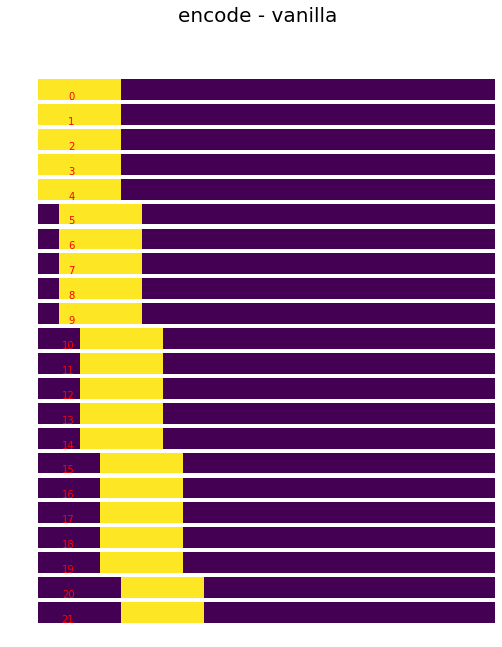

In [15]:
encoder = ScalarEncoder(w=3, out_size=22, min_val=2.5, max_val=97.5)
fig = plt.figure(figsize=(10,10))
fig.suptitle("encode - vanilla", fontsize=20)
num = encoder.out_size

for i in range(num):
    data = encoder.encode_vanilla(i).reshape(1,encoder.out_size)
    ax = plt.subplot(num,1,i+1)
    plt.imshow(data)
    bounds = list(ax.get_position().bounds)
    x, y, cx, cy = bounds
    plt.axis('off')
    fig.text(x + .05, y, i, fontsize=10, horizontalalignment='right', color= 'red')

In [12]:
print("0 =", encoder.encode_vanilla(1))
print("3 =", encoder.encode_vanilla(3))
print("4 =", encoder.encode_vanilla(4))
print("5 =", encoder.encode_vanilla(5))
print("5 =", encoder.encode_vanilla(5))
print("6 =", encoder.encode_vanilla(6))
print("7 =", encoder.encode_vanilla(7))

2.5
minbin: 0
maxbin: 3
0 = [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
3
minbin: 0
maxbin: 3
3 = [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
4
minbin: 0
maxbin: 3
4 = [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
5
minbin: 1
maxbin: 4
5 = [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
5
minbin: 1
maxbin: 4
5 = [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
6
minbin: 1
maxbin: 4
6 = [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
7
minbin: 1
maxbin: 4
7 = [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]


In [13]:
print("3 =   ", encoder.encode_vanilla(3))
print("4 =   ", encoder.encode_vanilla(4))
print("5 =   ", encoder.encode_vanilla(5))
print()
print("100 = ", encoder.encode_vanilla(100))
print("1000 =", encoder.encode_vanilla(1000))

3
minbin: 0
maxbin: 3
3 =    [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
4
minbin: 0
maxbin: 3
4 =    [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
5
minbin: 1
maxbin: 4
5 =    [ 0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]

97.5
minbin: 19
maxbin: 22


AssertionError: 

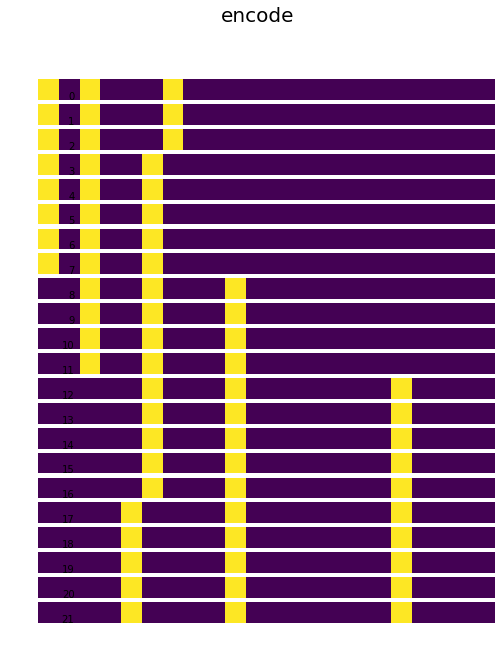

In [102]:
fig_2 = plt.figure(figsize=(10,10))
fig_2.suptitle("encode", fontsize=20)

for i in range(num):
    data_2 = encoder.encode(i).reshape(1,encoder.out_size)
    ax_2 = plt.subplot(num,1,i+1)
    plt.imshow(data_2)
    bounds = list(ax_2.get_position().bounds)
    x, y, cx, cy = bounds
    plt.axis('off')
    fig_2.text(x + .05, y, i, fontsize=10, horizontalalignment='right')

In [6]:
class CategoryEncoder:
    '''
    간단한 카테고리 encoder
    겹치지않게 만든다.
    '''
    def __init__(self, category, w=3):
        self.category = category
        self.category_count = len(category)
        self.active_bits = w
        self.total_bit = self.category_count * self.active_bits
        self.encoded_data = np.zeros(self.total_bit)
    
    def encode(self, item):
        if(item not in self.category):
            print('N/A')
            return None
        
        start_bit = self.category.index(item) + (self.active_bits - 1)*self.category.index(item)
        self.encoded_data[start_bit : start_bit+self.active_bits] = 1
        
        return self.encoded_data

In [7]:
ce = CategoryEncoder(['1','2','3'])
ce.encode('1')

array([ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [8]:
class CycleEncoder:
    '''
    겹치게 만든다.
    case by case 로 hardcoding 이 필요함.
    '''
    def __init__(self, category, active_bits=3, resolution=5):
        self.category = category
        self.category_count = len(category)
        self.active_bits = active_bits
        self.resolution = resolution
        self.total_bit = self.category_count * self.resolution
        self.encoded_data = np.zeros(self.total_bit)
    
    def encode(self, time):
        #start_bit = 
        
        return self.encoded_data

In [9]:
class CategoryEncoder:
    '''
    간단한 카테고리 encoder
    겹치지않게 만든다.
    '''
    def __init__(self, category, active_bits=3):
        self.category = category
        self.category_count = len(category)
        self.active_bits = active_bits
        self.total_bit = self.category_count * self.active_bits
        self.encoded_data = np.zeros(self.total_bit)
    
    def encode(self, item):
        if(item not in self.category):
            print('N/A')
            return None
        
        start_bit = self.category.index(item) + (self.active_bits - 1)*self.category.index(item)
        self.encoded_data[start_bit : start_bit+self.active_bits] = 1
        
        return self.encoded_data

In [10]:
def WeekEncoder(day):
    '''
    주중과 주말을 category 화 하여 encoding.
    - SUN - MON - TUE - WED - THU - FRI - SAT -
    겹치지않게 만든다.
    '''
    data_size = 10
    
    if(day == 'SUN' or day == 'SAT'):
        start_bit = 0
    elif(day == 'MON' or day == 'TUE' or day == 'WED' or 
         day == 'THU' or day == 'FRI'):
        start_bit = int(data_size / 2)
    else:
        print("N/A")
        return 0
        
    encoded_data = np.zeros(data_size)
    encoded_data[start_bit : start_bit + int(data_size/2)] = 1
    
    return encoded_data